In [20]:
% matplotlib inline
import requests, warnings, json, time, os, re
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

### IOOS Southern Ocean Data requests

Ask Sheri about the Water pCO2 <br>
DO - looks bad (Be weary)!

__Creating a credentials file__ <br>
This is done so you aren't uploading your private token and username onto a github repo for the whole world to see

1. Create a file called credentials.json in this folder.
2. Add your token and username info so it looks something like this:

```
{
    "username": "OOIAPI-FAKEAPINAME",
    "token": "BBN3YLYO783"
}

```

In [29]:
# Load your credentials
with open("credentials.json", "r") as read_file:
    data = json.load(read_file)
token = data['token']
username = data['username']

### Pull Surface CTD Data from the [Apex Surface Mooring](http://ooi.visualocean.net/instruments/view/GS01SUMO-RID16-03-CTDBPF000)

Example M2M url:
https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv/GS01SUMO/RID16/03-CTDBPF000/metadata

In [30]:
# Build API Query
DATA_API_BASE_URL = 'https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv/'
data_request_url = DATA_API_BASE_URL+\
                    'GS01SUMO/'+\
                    'RID16/'+\
                    '03-CTDBPF000/'+\
                    'telemetered/'+\
                    'ctdbp_cdef_dcl_instrument'+'?'

r = requests.get(data_request_url, params=None, auth=(username, token)) # Request data
data = r.json() # verify request

In [31]:
# if data says something about a 404 message, double check the API url. Otherwwi
print(data)

{'timeCalculation': 159, 'numberOfSubJobs': 675, 'allURLs': ['https://opendap.oceanobservatories.org/thredds/catalog/ooi/pdaniel@mbari.org/20180822T225533-GS01SUMO-RID16-03-CTDBPF000-telemetered-ctdbp_cdef_dcl_instrument/catalog.html', 'https://opendap.oceanobservatories.org/async_results/pdaniel@mbari.org/20180822T225533-GS01SUMO-RID16-03-CTDBPF000-telemetered-ctdbp_cdef_dcl_instrument'], 'sizeCalculation': 757591454, 'requestUUID': 'fcc0f0ce-56c4-4119-b4ac-f46d184a6f0a', 'outputURL': 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/pdaniel@mbari.org/20180822T225533-GS01SUMO-RID16-03-CTDBPF000-telemetered-ctdbp_cdef_dcl_instrument/catalog.html'}


__Waiting for the dataset to be built and sent to your THREDDS__

In [32]:
%%time
check_complete = data['allURLs'][1] + '/status.txt'
for i in range(1800): 
    r = requests.get(check_complete)
    if r.status_code == requests.codes.ok:
        print('request completed')
        break
    else:
        time.sleep(1)

CPU times: user 41 s, sys: 3.15 s, total: 44.2 s
Wall time: 39min 24s


### Pull the data from Thredds ###

This chunk of code scrapes the thredds server associated with your username and finds each of the netCDF files that are associated with each deployment (three files in this case) and puts there URLs into a list

In [12]:
url = data['allURLs'][0]
tds_url = 'https://opendap.oceanobservatories.org/thredds/dodsC'
datasets = requests.get(url).text
urls = re.findall(r'href=[\'"]?([^\'" >]+)', datasets)
x = re.findall(r'(ooi/.*?.nc)', datasets)
for i in x:
    if i.endswith('.nc') == False:
        x.remove(i)
for i in x:
    try:
        float(i[-4])
    except:
        x.remove(i)
datasets = [os.path.join(tds_url, i) for i in x]
datasets

['https://opendap.oceanobservatories.org/thredds/dodsC/ooi/pdaniel@mbari.org/20180822T045324-GS01SUMO-RID16-03-CTDBPF000-telemetered-ctdbp_cdef_dcl_instrument/deployment0003_GS01SUMO-RID16-03-CTDBPF000-telemetered-ctdbp_cdef_dcl_instrument_20161125T011706.633000-20180821T234514.654000.nc',
 'https://opendap.oceanobservatories.org/thredds/dodsC/ooi/pdaniel@mbari.org/20180822T045324-GS01SUMO-RID16-03-CTDBPF000-telemetered-ctdbp_cdef_dcl_instrument/deployment0002_GS01SUMO-RID16-03-CTDBPF000-telemetered-ctdbp_cdef_dcl_instrument_20151214T202006.149000-20161205T090522.930000.nc',
 'https://opendap.oceanobservatories.org/thredds/dodsC/ooi/pdaniel@mbari.org/20180822T045324-GS01SUMO-RID16-03-CTDBPF000-telemetered-ctdbp_cdef_dcl_instrument/deployment0001_GS01SUMO-RID16-03-CTDBPF000-telemetered-ctdbp_cdef_dcl_instrument_20150218T211507.035000-20150611T000008.454000.nc']

Xarray is amazing and can open multiple netCDF files if they have the same Coordinates, (which each instrument deployment should have!). 

These data a thrown into a xarray Dataset (this is sort of the fundamental unit of xarray and is basically a 3-D array (or more) that keeps some track of some of the metadata)

In [7]:
datasets = ['https://opendap.oceanobservatories.org/thredds/dodsC/ooi/pdaniel@mbari.org/20180822T045324-GS01SUMO-RID16-03-CTDBPF000-telemetered-ctdbp_cdef_dcl_instrument/deployment0003_GS01SUMO-RID16-03-CTDBPF000-telemetered-ctdbp_cdef_dcl_instrument_20161125T011706.633000-20180821T234514.654000.nc',
 'https://opendap.oceanobservatories.org/thredds/dodsC/ooi/pdaniel@mbari.org/20180822T045324-GS01SUMO-RID16-03-CTDBPF000-telemetered-ctdbp_cdef_dcl_instrument/deployment0002_GS01SUMO-RID16-03-CTDBPF000-telemetered-ctdbp_cdef_dcl_instrument_20151214T202006.149000-20161205T090522.930000.nc',
 'https://opendap.oceanobservatories.org/thredds/dodsC/ooi/pdaniel@mbari.org/20180822T045324-GS01SUMO-RID16-03-CTDBPF000-telemetered-ctdbp_cdef_dcl_instrument/deployment0001_GS01SUMO-RID16-03-CTDBPF000-telemetered-ctdbp_cdef_dcl_instrument_20150218T211507.035000-20150611T000008.454000.nc']

In [14]:
data_url = "https://opendap.oceanobservatories.org/thredds/dodsC/ooi/pdaniel@mbari.org/20180822T045324-GS01SUMO-RID16-03-CTDBPF000-telemetered-ctdbp_cdef_dcl_instrument/deployment0003_GS01SUMO-RID16-03-CTDBPF000-telemetered-ctdbp_cdef_dcl_instrument_20161125T011706.633000-20180821T234514.654000.nc"
ds = xr.open_dataset(data_url)

In [15]:
ds

<xarray.Dataset>
Dimensions:                         (obs: 63423)
Coordinates:
  * obs                             (obs) int32 0 1 2 3 4 5 6 7 8 9 10 11 12 ...
    time                            (obs) datetime64[ns] ...
    pressure                        (obs) float64 ...
    lat                             (obs) float64 ...
    lon                             (obs) float64 ...
Data variables:
    deployment                      (obs) int32 ...
    id                              (obs) |S64 ...
    conductivity                    (obs) float64 ...
    date_time_string                (obs) object ...
    dcl_controller_timestamp        (obs) object ...
    driver_timestamp                (obs) datetime64[ns] ...
    ingestion_timestamp             (obs) datetime64[ns] ...
    internal_timestamp              (obs) datetime64[ns] ...
    port_timestamp                  (obs) datetime64[ns] ...
    preferred_timestamp             (obs) object ...
    provenance                      (obs)

In [8]:
ds = xr.open_mfdataset(datasets)
ds = ds.swap_dims({'obs': 'time'})
ds = ds.sortby('time') # data from different deployments can overlap so we want to sort all data by time stamp.

Lets print the data varaibles and the corresponding standard names

In [9]:
for var in ds.variables:
    try:
        print(ds[var].standard_name + ':', var)
    except: #hack to only print variables that have a standard name attribute
        pass

time: time
sea_water_electrical_conductivity: conductivity
sea_water_pressure: pressure
sea_water_temperature: temp
sea_water_practical_salinity: practical_salinity
sea_water_density: density
latitude: lat
longitude: lon


Plot the Temperature timeseries and the QC flags

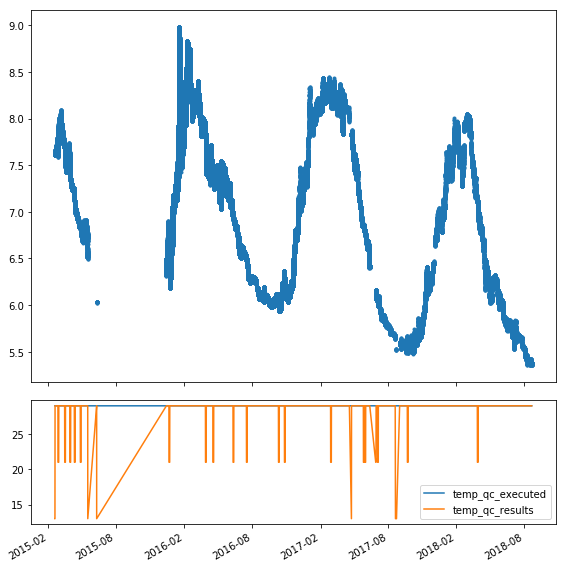

In [17]:
fig, (ax, ax_qc) = plt.subplots(2,sharex=True,gridspec_kw={'height_ratios':[3, 1]})
fig.set_size_inches(8,8)
ax.plot(ds['time'], ds['temp'], marker='.', linewidth=0)
ax.set_ylabel('Temperature')
ax_qc.plot(ds['time'], ds['temp_qc_executed'],marker='.', linewidth=0)
ax_qc.plot(ds['time'], ds['temp_qc_results'],marker='.', linewidth=0)
ax_qc.legend()

fig.autofmt_xdate()
fig.tight_layout()


In [24]:
dateTime = ds['time'].values
np.nanmean(np.diff(dateTime) / np.timedelta64(1, 's')) / 60

14.41626145002265

In [33]:
ds = xr.open

AttributeError: module 'xarray' has no attribute 'open'